# Assignment 2: Machine Learning


You have 10 days to work on a machine learning algorithm.
I want you to pick one of the following use cases and make a prediction algorithm using either regression or classification algorithms.

Do the following:
1. Pick one use case (defined below).
    - We went with Use Case 2  
2. Explore and research which algorithm would work best for this use case (regression or classification)
    - Regression
3. Document your findings in a file (3-5 lines) on why you chose this algorithm.
    - We think Regression being the best, seing as we are not looking for a binary value of higher or lower, but rather "how high" and "how low", we are looking for a nuanced value, and therefore regression in the best fit.


TODO:

- Clean data properly

4. Train the algorithm using Python
5. Keep the solution as simple as possible. We are not looking for the best machine learning algorithm. We are interested in seeing that you know how to work with machine learning.
6. Publish the code on GitHub and send us the link


## Use Case 2 - Predict passenger data for Ruter
Use the same data set given to you in assignment 1. I want you to make a prediction algorithm which predicts the number of passengers on a specific date for a specific bus (pick any one). Input should be date and output will be number of passengers
You should also show the  prediction percentage score. Data file: Ruter_data.csv


In [257]:
# Imports

# numpy for math
import numpy as np
# pandas for dataframes
import pandas as pd
#importing datetime for format conversion
import datetime as dt

#improts for plott
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")


# importing ai stuff
from sklearn import metrics
# from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [258]:
"""
First staring with making the .csv more manageable
"""

dataf = pd.read_csv("Ruter-data.csv", sep=";")

print(dataf["Linjenavn"].value_counts())
print(len(dataf.index))

100     465
110     362
390     247
31      220
360     189
       ... 
3772      1
3575      1
3833      1
3335      1
452       1
Name: Linjenavn, Length: 150, dtype: int64
6000


In [259]:
# We are only going to predict a single bus route, so dropping every other route, reducing from 6000 rows to just 110 rows
dataf = dataf[dataf['Linjenavn'] == "100"]

# Also dropping negative passager values, as these must be sensor misreadings
dataf = dataf[dataf['Passasjerer_Ombord'] >= 0]


print(dataf["Linjenavn"].value_counts())
print(len(dataf.index))

100    423
Name: Linjenavn, dtype: int64
423


In [260]:
# Testing to see if any columns could be dropped

print(dataf["Fylke"].value_counts())
print(dataf["Område"].value_counts())
print(dataf["Kommune"].value_counts())
print(dataf["Linjetype"].value_counts())
print(dataf["Linjefylke"].value_counts())
print(dataf["Kjøretøy_Kapasitet"].value_counts())


# Seems like linjetype, linjefylke and kjøretøy kapasitet can be dropped, as they contain the same value across the board
# Linjenavn can also be dropped, as of course, that is the same in every value, we just need to remember that it was for bus 150 hahah

Viken    252
Oslo     171
Name: Fylke, dtype: int64
Nordøst     378
Indre By     45
Name: Område, dtype: int64
Lillestrøm    169
Alna          101
Lørenskog      83
Gamle Oslo     45
Stovner        19
Bjerke          6
Name: Kommune, dtype: int64
Lokal    423
Name: Linjetype, dtype: int64
Viken    423
Name: Linjefylke, dtype: int64
151    423
Name: Kjøretøy_Kapasitet, dtype: int64


In [261]:
dataf.drop({'Linjetype', 'Linjefylke', 'Kjøretøy_Kapasitet', 'Linjenavn'}, axis=1, inplace=True)

dataf.head(1)

,TurId,Dato,Fylke,Område,Kommune,Holdeplass_Fra,Holdeplass_Til,Linjeretning,Tidspunkt_Faktisk_Ankomst_Holdeplass_Fra,Tidspunkt_Faktisk_Avgang_Holdeplass_Fra,Tidspunkt_Planlagt_Ankomst_Holdeplass_Fra,Tidspunkt_Planlagt_Avgang_Holdeplass_Fra,Passasjerer_Ombord
38,10008-2020-08-09T11:24:00+02:00,09/08/2020,Viken,Nordøst,Lillestrøm,Sagdalen,Sagdalen skole,0,11:38:58,11:39:06,11:38:00,11:38:00,1


In [262]:
# Converting first to pandas time format, you can see the change in the Dato column, goes from "/" format to "-" format

dataf['Dato'] = pd.to_datetime(dataf['Dato'], errors='coerce')

dataf.head(1)

,TurId,Dato,Fylke,Område,Kommune,Holdeplass_Fra,Holdeplass_Til,Linjeretning,Tidspunkt_Faktisk_Ankomst_Holdeplass_Fra,Tidspunkt_Faktisk_Avgang_Holdeplass_Fra,Tidspunkt_Planlagt_Ankomst_Holdeplass_Fra,Tidspunkt_Planlagt_Avgang_Holdeplass_Fra,Passasjerer_Ombord
38,10008-2020-08-09T11:24:00+02:00,2020-09-08,Viken,Nordøst,Lillestrøm,Sagdalen,Sagdalen skole,0,11:38:58,11:39:06,11:38:00,11:38:00,1


In [263]:
# Turning the pandas datetime format to a number value, determining distance from the date "01.01.01"

dataf['Dato'] = dataf['Dato'].map(dt.datetime.toordinal)

dataf.head(1)

,TurId,Dato,Fylke,Område,Kommune,Holdeplass_Fra,Holdeplass_Til,Linjeretning,Tidspunkt_Faktisk_Ankomst_Holdeplass_Fra,Tidspunkt_Faktisk_Avgang_Holdeplass_Fra,Tidspunkt_Planlagt_Ankomst_Holdeplass_Fra,Tidspunkt_Planlagt_Avgang_Holdeplass_Fra,Passasjerer_Ombord
38,10008-2020-08-09T11:24:00+02:00,737676,Viken,Nordøst,Lillestrøm,Sagdalen,Sagdalen skole,0,11:38:58,11:39:06,11:38:00,11:38:00,1


In [264]:
# Setting data to a more sensible value, having day 1 being
# TODO: Might also have to group on date

# Figuring out the distance between dates based on max and min date 
print(max(dataf['Dato']) - min(dataf['Dato']))

# Storing this for later in case we want to correct the data back again
dateReduction = min(dataf['Dato']) - 1 

# Like this, first date should have a value of 1
dataf['Dato'] = dataf['Dato'] - dateReduction 

# Checking that we do not in fact have a 0 value
print(min(dataf['Dato'])) 

337
1


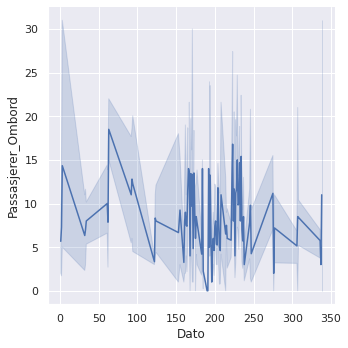

In [265]:
# Task is to predict passengers per day, so doing a quick relplot thus far

sns.relplot(x="Dato", y="Passasjerer_Ombord", kind="line", data=dataf)

# Guessing that the lack of precission is due to lack of grouping

In [266]:
# We see that a lot of days have multiple counts, and we need to group them, 110 rows are spread over 43 unique dates
print(len(dataf["Dato"].value_counts()))

90


In [267]:
"""
Sources that helped with this grouping and such:
https://www.geeksforgeeks.org/pandas-groupby/?ref=lbp
https://towardsdatascience.com/all-pandas-groupby-you-should-know-for-grouping-data-and-performing-operations-2a8ec1327b5

Espescially this one:
https://www.askpython.com/python-modules/pandas/conditionally-grouping-values

https://stackoverflow.com/questions/26323926/pandas-groupby-agg-how-to-return-results-without-the-multi-index
"""

"""
We went with using mean instead of sum, as there were super unreliable data in this dataset. Some days have no recordings, other have a few, but none have the actual data, containing every trip for every bus in that line, on a given day. Therefore it would not make sense to sum the passengers together as the sums would mean nothing without complete data
"""
dataf = dataf.groupby('Dato', axis=0, as_index=False).mean()

#engineering feature for weekday
dataf['Ukedag'] = dataf['Dato'] % 7

# dataf = dataf['Passasjerer_Ombord'].agg(np.mean)

"""
btw, either i did something massively wrong, or like this dataset is quite lacking, it doesn't even have daily entries on this bus, that goes like 4 times per hour every day, what is that all about?
"""

dataf

,Dato,Linjeretning,Passasjerer_Ombord,Ukedag
0,1,0.666667,5.666667,1
1,2,0.571429,7.285714,2
2,3,0.666667,14.333333,3
3,32,0.333333,6.333333,4
4,33,0.363636,7.000000,5
...,...,...,...,...
85,307,0.250000,8.500000,6
86,308,0.600000,8.400000,0
87,336,0.500000,5.750000,0
88,337,1.000000,3.000000,1


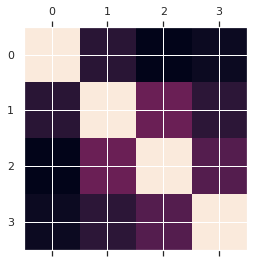

,Dato,Linjeretning,Passasjerer_Ombord,Ukedag
Dato,1.000000,-0.007989,-0.132578,-0.095265
Linjeretning,-0.007989,1.000000,0.178383,0.004452
Passasjerer_Ombord,-0.132578,0.178383,1.000000,0.119183
Ukedag,-0.095265,0.004452,0.119183,1.000000


In [268]:
# Just quickly checking for any correlation

corrMatrix = dataf.corr()
plt.matshow(corrMatrix)
plt.show()

corrMatrix.style.background_gradient(cmap='coolwarm')

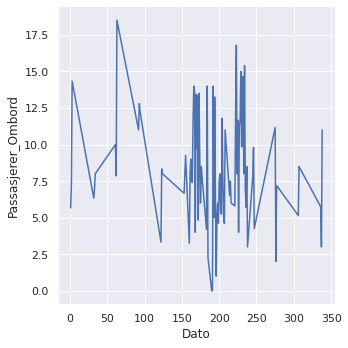

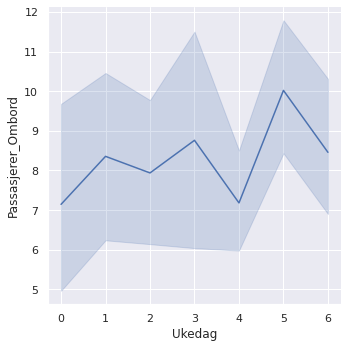

In [269]:
sns.relplot(x="Dato", y="Passasjerer_Ombord", kind="line", data=dataf)
sns.relplot(x="Ukedag", y="Passasjerer_Ombord", kind="line", data=dataf)


# even thought the other columns got a bit scuffed, then we see that the plot itself becomes much cleaner
# Grouping on weekday might give us better values for regression algorithm

In [270]:
"""
Setting x to be weekday
y to be passengers
"""

# TRAINING THE MODELS
X = pd.DataFrame(dataf['Dato']) #Var1
X1 = pd.DataFrame(dataf['Ukedag']) #Var1

y = pd.DataFrame(dataf['Passasjerer_Ombord']) #Result

"""
THIS IS THE PART WHERE WE STEAL EVERYTHING FROM LAB 4
"""

#Now, split the set in training and testing sets
#test_size = 0.33 tell the function that 1/3 of values should be put in test arrat
#Random state is a variable that seeds the random generator. In that way
#you'll get the same training and testing set each run
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y, test_size=0.33, random_state=42)

In [271]:
#Date stuff
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X_train, y_train)  # perform linear regression
Y_pred = linear_regressor.predict(X_train)  # make predictions


#Weekday stuff
linear_regressor1 = LinearRegression()  # create object for the class
linear_regressor1.fit(X1_train, y1_train)  # perform linear regression
Y1_pred = linear_regressor.predict(X1_train)  # make predictions

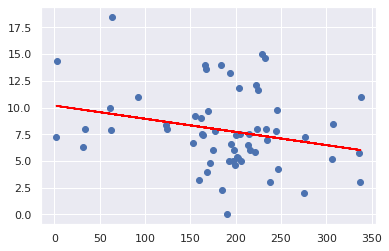

MSE = 12.349483126587252


In [272]:
#Plotting result against result column
plt.scatter(X_train, y_train)             #Plot blue dots with real data
plt.plot(X_train, Y_pred, color='red')    #Plot red line with prediction
plt.show()                                #Show the plot
print( "MSE = "+str(metrics.mean_squared_error(y_train,Y_pred))) #Calculate MSE

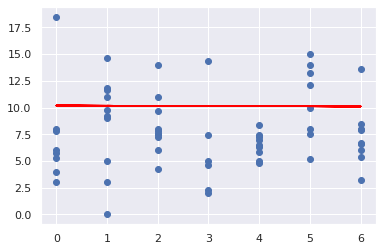

MSE = 18.421691493993517


In [273]:
#Plotting result against result column
plt.scatter(X1_train, y1_train)             #Plot blue dots with real data
plt.plot(X1_train, Y1_pred, color='red')    #Plot red line with prediction
plt.show()                                #Show the plot
print( "MSE = "+str(metrics.mean_squared_error(y1_train,Y1_pred))) #Calculate MSE

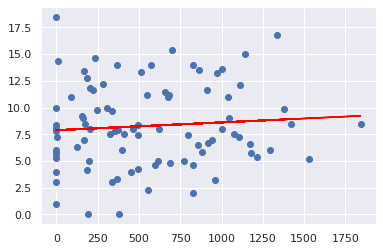

MSE = 14.725550432188953


In [274]:
dataf['UkeDato'] = dataf['Dato']*dataf['Ukedag']  #Create a new var, based on Var1 and Var3

X = pd.DataFrame(dataf['UkeDato'])  #Lets skip making train test set for now, and just
Y = pd.DataFrame(dataf['Passasjerer_Ombord'])  #load the entire dataset
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()
print( "MSE = "+str(metrics.mean_squared_error(Y,Y_pred)))

In [277]:
linear_regressor.predict([[500*5]]) #Expected output = 9-10ish, passengers for that day, as it is far into the future and the line is slowly climbing

array([[9.70595227]])

# Conclusion

With a limited dataset, our reading become quite bad, and our prediction 